In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools


from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Input, BatchNormalization, Conv2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model


np.random.seed(198)

In [2]:
# Data Preparation

data = pd.read_csv("../input/kan_mnist.csv")
classname = [str(n) for n in data.label.unique()]

X, y = [],[]
for i in range(len(data)):
    re_X, re_y = data.iloc[i, 1:].values.reshape(28,28), data.iloc[i].label   
    X.append(np.array(re_X))
    y.append(np.array(re_y))
    
X = np.array(X)
y = np.array(y)
print(X.shape, y.shape)

# data split
X_train, y_train = X[:50000], y[:50000] 
X_test, y_test = X[50000:], y[50000:] 

if len(X_train.shape) < 4:
    X_train = np.expand_dims(X_train, -1)
    X_test = np.expand_dims(X_test, -1)

input_shape = X_train.shape[1:]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize data
X_train = X_train / 256.0
X_test = X_test / 256.0

nb_classes = y_train.max()+1

# label to categorical 
y_test_cat = to_categorical(y_test, nb_classes)
y_train_cat = to_categorical(y_train, nb_classes)

(60000, 28, 28) (60000,)


In [3]:
# convolution neural network
def Create_CNN(input_shape, nb_classes):
    model_input = Input(shape=input_shape)
    x = Conv2D(16, kernel_size=3, activation='relu')(model_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, kernel_size=3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, kernel_size=3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, kernel_size=3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, kernel_size=3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    flatten = Flatten()(x)
    output = Dense(nb_classes, use_bias=True, activation='softmax')(flatten)

    model = Model(inputs=model_input, outputs=output)

    model.summary()

    return model

In [4]:
cnn_model = Create_CNN(input_shape=input_shape, nb_classes=nb_classes)

optimiser = Adam(lr=0.013, decay=0.001)
cnn_model.compile(loss='categorical_crossentropy',
              optimizer=optimiser,
              metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 26, 26, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128   

In [5]:
epoch = 10
cnn_history = cnn_model.fit(x=X_train,
          y=y_train_cat,
          batch_size=265,
          epochs=epoch,
          validation_data=(X_test, y_test_cat),
          shuffle=True,
          verbose=1
          )

Epoch 1/10
189/189 [==============================] - 75s 398ms/step - loss: 0.7455 - accuracy: 0.9134 - val_loss: 0.2117 - val_accuracy: 0.9352
Epoch 2/10
189/189 [==============================] - 73s 384ms/step - loss: 0.0414 - accuracy: 0.9880 - val_loss: 1.0349 - val_accuracy: 0.6608
Epoch 3/10
189/189 [==============================] - 73s 387ms/step - loss: 0.0278 - accuracy: 0.9915 - val_loss: 0.6562 - val_accuracy: 0.8299
Epoch 4/10
189/189 [==============================] - 72s 383ms/step - loss: 0.0211 - accuracy: 0.9935 - val_loss: 0.0194 - val_accuracy: 0.9940
Epoch 5/10
189/189 [==============================] - 73s 389ms/step - loss: 0.0161 - accuracy: 0.9952 - val_loss: 0.0410 - val_accuracy: 0.9893
Epoch 6/10
189/189 [==============================] - 74s 389ms/step - loss: 0.0142 - accuracy: 0.9960 - val_loss: 0.0346 - val_accuracy: 0.9892
Epoch 7/10
189/189 [==============================] - 73s 387ms/step - loss: 0.0107 - accuracy: 0.9966 - val_loss: 0.0383 - val_ac

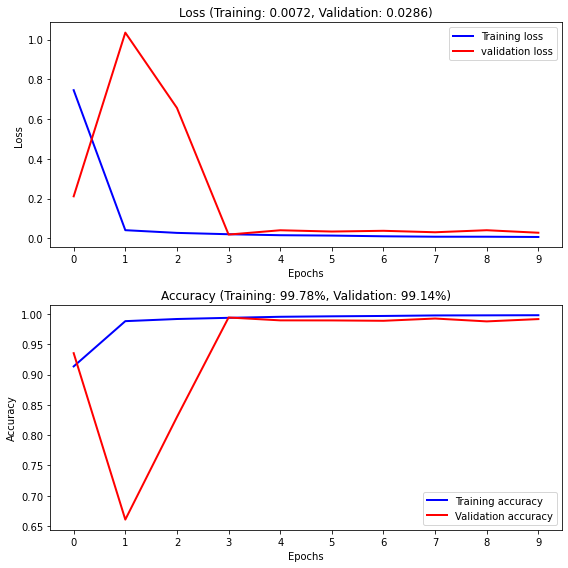

In [6]:
# Evaluation

def plot_training(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
    plt.title("CNN")
    ax1.plot(history.history['loss'], color='b', label="Training loss", linewidth=2)
    ax1.plot(history.history['val_loss'], color='r', label="validation loss", linewidth=2)
    ax1.set_xticks(np.arange(0, epoch, 1))
    ax1.title.set_text("Loss (Training: "+str(round(history.history['loss'][-1],4))+", Validation: "+str(round(history.history['val_loss'][-1],4))+")")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc='best', shadow=False)

    ax2.plot(history.history['accuracy'], color='b', label="Training accuracy", linewidth=2)
    ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy", linewidth=2)
    ax2.set_xticks(np.arange(0, epoch, 1))
    ax2.title.set_text("Accuracy (Training: "+str(round(history.history['accuracy'][-1]*100,2))+"%, Validation: "+str(round(history.history['val_accuracy'][-1]*100,2))+"%)")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.legend(loc='lower right', shadow=False)
    plt.rcParams.update({'font.size': 10})
    
    plt.tight_layout()
    plt.savefig('results/cnn.png', bbox_inches='tight', dpi=200)
    plt.show()

plot_training(cnn_history)

313/313 [==============================] - 3s 11ms/step - loss: 0.0286 - accuracy: 0.9914

Best Keras validation accuracy is : 99.140000 



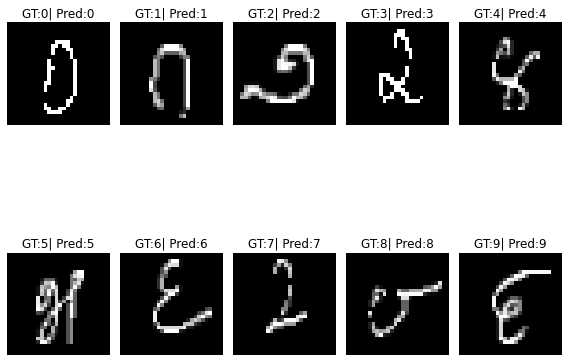

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1000
           1       1.00      1.00      1.00      1000
           2       0.98      1.00      0.99      1000
           3       0.99      0.99      0.99      1000
           4       0.99      0.99      0.99      1000
           5       1.00      0.96      0.98      1000
           6       1.00      0.98      0.99      1000
           7       0.97      0.99      0.98      1000
           8       1.00      1.00      1.00      1000
           9       1.00      1.00      1.00      1000

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



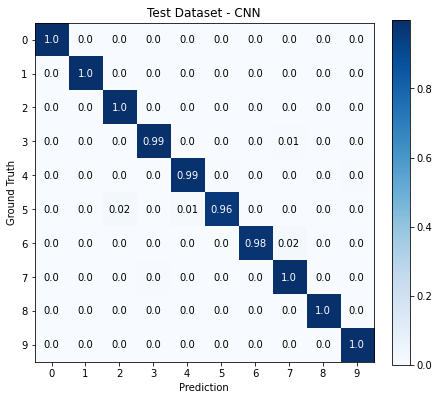

In [7]:
cnn_model.save('saved_models/cnn_model.h5')

cnnTest = load_model(filepath='saved_models/cnn_model.h5')

validationAccuracy = cnnTest.evaluate(X_test, y_test_cat, verbose=1)
print('\nBest Keras validation accuracy is : %f \n' % (100.0 * validationAccuracy[1]))

pred = cnnTest.predict(X_test)

fig, axes = plt.subplots(2, 5, figsize=(8,8))
for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(X_test[i], cmap=plt.get_cmap('gray'))
    
    ax.set_title(f"GT:{np.argmax(y_test_cat[i+20])}| Pred:{np.argmax(pred[i+20])}")
    ax.axis("off")
    
plt.tight_layout()
plt.show()

# Confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Test Dataset',
                          cmap=plt.cm.Blues,
                          save=0):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    
    plt.title(title)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classname)
    plt.yticks(tick_marks, classname)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.tight_layout()
    sh = plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.colorbar(sh,fraction=0.046)
    if save!=0:
      plt.savefig(save+'_cm.jpg',dpi=300)

X_train_pred = np.argmax(pred,axis=1)
X_train_true = np.argmax(y_test_cat,axis=1)

f1_report = classification_report(X_train_true, X_train_pred, target_names=classname)
print(f1_report)
with open("results/cnn_f1_report.txt", "w") as f:
    f.write(f1_report)

train_confusion_mtx = confusion_matrix(X_train_true, X_train_pred)
# plot the confusion matrix
plot_confusion_matrix(train_confusion_mtx,classes = range(len(classname)),title="Test Dataset - CNN", save='results/cnn') 
# plot_confusion_matrix(train_confusion_mtx,classes = range(len(classname)), save='output/latest_distress_v2_cnn_P92') 